# Load the necessary modules.

In [1]:
import jax.numpy as jnp
import rheedium as rh

### Use `autoreload` to reload changed modules, you may disable this for normal use.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
structure_file = rh.inout.parse_cif("../tests/test_data/SrTiO3.cif")

In [4]:
structure_file

CrystalStructure(frac_positions=Array([[5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 3.80000000e+01],
       [1.70215563e-33, 1.70215563e-33, 5.00000000e-01, 2.20000000e+01]],      dtype=float64), cart_positions=Array([[1.97256507e+00, 1.97256507e+00, 1.97256506e+00, 3.80000000e+01],
       [1.20784775e-16, 1.20784775e-16, 1.97256506e+00, 2.20000000e+01]],      dtype=float64), cell_lengths=Array([3.94513013, 3.94513013, 3.94513013], dtype=float64), cell_angles=Array([90., 90., 90.], dtype=float64))

In [5]:
zone_axis = jnp.array([1, 1, 1])
thickness = jnp.asarray([12, 12, 2])

# Now, load the parameters

In [6]:
voltage_kV = 20.0  # Electron beam voltage in kV
theta_deg = 2.0  # Grazing angle
hmax, kmax = 4, 4  # In-plane reciprocal lattice bounds
detector_distance = 100.0  # Detector distance in mm
points_per_streak = 100  # Points to sample along each CTR streak

# Now, we will process things step by step.

## Electron wavelength (Å)

In [7]:
lam_ang = rh.simul.wavelength_ang(voltage_kV)
lam_ang

Array(0.08585529, dtype=float64, weak_type=True)

## Build real-space lattice vectors

In [8]:
cell_vectors = rh.ucell.build_cell_vectors(
    *structure_file.cell_lengths, *structure_file.cell_angles
)

In [9]:
cell_vectors

Array([[3.94513013e+00, 0.00000000e+00, 0.00000000e+00],
       [2.41569549e-16, 3.94513013e+00, 0.00000000e+00],
       [2.41569549e-16, 2.41569549e-16, 3.94513013e+00]], dtype=float64)

## Generate reciprocal lattice vectors

In [10]:
# For reference: generate bulk reciprocal lattice points
lmax = 2  # For visualization only
Gs = rh.ucell.generate_reciprocal_points(
    crystal=structure_file, hmax=hmax, kmax=kmax, lmax=lmax, in_degrees=True
)
print(f"Reciprocal lattice points (for reference): {Gs.shape[0]}")

Reciprocal lattice points (for reference): 405


## Incident wavevector

In [11]:
k_in = rh.simul.incident_wavevector(lam_ang, theta_deg)

## Allowed reflections by kinematic scattering conditions

In [12]:
# For reference: find discrete Bragg reflections (bulk-like)
tolerance = 0.1
allowed_indices, k_out = rh.simul.find_kinematic_reflections(
    k_in=k_in,
    gs=Gs,
    tolerance=tolerance,
)
print(f"Discrete Bragg reflections: {len(allowed_indices)}")
print("Note: RHEED from surfaces shows continuous streaks, not discrete spots!")

Discrete Bragg reflections: 5
Note: RHEED from surfaces shows continuous streaks, not discrete spots!


## Simulate RHEED streak pattern using Crystal Truncation Rods (CTRs)

The `streak_simulator` models RHEED as diffraction from continuous rods in reciprocal space,
producing the characteristic vertical streaks seen in real RHEED patterns.

In [13]:
# Generate RHEED streak pattern for SrTiO3
detector_coords, intensities, hk_indices = rh.simul.streak_simulator(
    crystal=structure_file,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    hmax=hmax,
    kmax=kmax,
    detector_distance=detector_distance,
    points_per_streak=points_per_streak,
)

print(f"Number of streak points: {len(intensities)}")
print(f"X-coordinate range: [{detector_coords[:, 0].min():.2f}, {detector_coords[:, 0].max():.2f}] mm")
print(f"Y-coordinate range: [{detector_coords[:, 1].min():.2f}, {detector_coords[:, 1].max():.2f}] mm")

Number of streak points: 1950
X-coordinate range: [-9.54, 9.54] mm
Y-coordinate range: [0.07, 49.65] mm


## Check how many reflections were found

In [14]:
# Summary of streak pattern
print(f"Number of streak points: {len(intensities)}")
print(f"Number of unique (h,k) rods: {len(jnp.unique(hk_indices, axis=0))}")
print(f"Intensity range: [{intensities.min():.3f}, {intensities.max():.3f}]")
print("\nSample detector coordinates (first 5):")
print(detector_coords[:5])

Number of streak points: 1950
Number of unique (h,k) rods: 39
Intensity range: [0.010, 1.000]

Sample detector coordinates (first 5):
[[-9.54131684  0.49112623]
 [-9.54131684  1.47337869]
 [-9.54131684  2.45563116]
 [-9.54131684  3.43788362]
 [-9.54131684  4.42013608]]


## Plot the simulated RHEED pattern

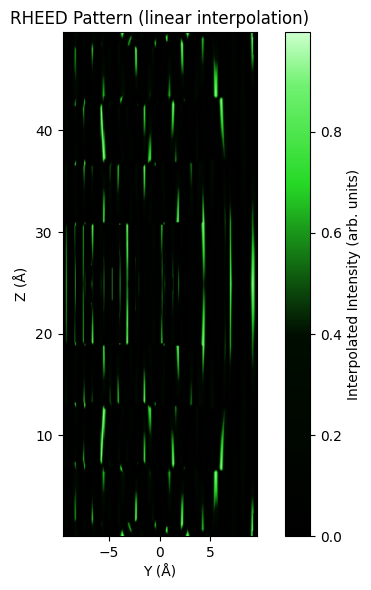

In [15]:
# Create RHEEDPattern for plotting
from rheedium.types import create_rheed_pattern

streak_pattern = create_rheed_pattern(
    g_indices=jnp.arange(len(intensities), dtype=jnp.int32),
    k_out=jnp.zeros((len(intensities), 3)),
    detector_points=detector_coords,
    intensities=intensities,
)

# Plot using phosphor colormap
rh.plots.plot_rheed(streak_pattern, grid_size=400, interp_type="linear")

# Understanding the RHEED Streak Pattern

## Physics of RHEED Streaks

The `streak_simulator` properly models RHEED from surfaces:

1. **Crystal Truncation Rods (CTRs)**: Surface breaks z-symmetry, creating continuous rods in reciprocal space
2. **Ewald Sphere Intersection**: Each (h,k) rod intersects the Ewald sphere along an arc
3. **Vertical Streaks**: Arc projections onto the detector create characteristic vertical lines

## Key Features:
- **Streak spacing**: Determined by in-plane reciprocal lattice (∝ 1/a)  
- **Intensity modulation**: CTR intensity varies as 1/sin²(πl), brightest at Bragg positions
- **Streak length**: Depends on Ewald sphere curvature and grazing angle

# SlicedCrystal for Oriented Surfaces

The `SlicedCrystal` type allows creating properly oriented surface slabs for more advanced simulations.

In [16]:
# Create a properly oriented [111] surface slab
slab_111 = rh.types.bulk_to_slice(
    bulk_crystal=structure_file,
    orientation=jnp.array([1, 1, 1]),  # (111) surface
    depth=20.0,  # 20 Å deep
    x_extent=150.0,  # 150 Å wide
    y_extent=150.0   # 150 Å tall
)

print(f"Created [111] surface slab:")
print(f"  Number of atoms: {slab_111.cart_positions.shape[0]}")
print(f"  Orientation: {slab_111.orientation}")
print(f"  Dimensions: {slab_111.x_extent} x {slab_111.y_extent} x {slab_111.depth} Å")
print(f"  Z range: {slab_111.cart_positions[:, 2].min():.2f} to {slab_111.cart_positions[:, 2].max():.2f} Å")

Created [111] surface slab:
  Number of atoms: 81
  Orientation: [1 1 1]
  Dimensions: 150.0 x 150.0 x 20.0 Å
  Z range: 0.00 to 18.22 Å


# Proper Solution: Using SlicedCrystal for True [111] Surface

The new `SlicedCrystal` type properly orients the crystal!

In [17]:
# Create a properly oriented [111] surface slab
slab_111 = rh.types.bulk_to_slice(
    bulk_crystal=structure_file,
    orientation=jnp.array([1, 1, 1]),  # (111) surface
    depth=20.0,  # 20 Å deep
    x_extent=150.0,  # 150 Å wide
    y_extent=150.0   # 150 Å tall
)

print(f"Created [111] surface slab:")
print(f"  Number of atoms: {slab_111.cart_positions.shape[0]}")
print(f"  Orientation: {slab_111.orientation}")
print(f"  Dimensions: {slab_111.x_extent} x {slab_111.y_extent} x {slab_111.depth} Å")
print(f"  Z range: {slab_111.cart_positions[:, 2].min():.2f} to {slab_111.cart_positions[:, 2].max():.2f} Å")

Created [111] surface slab:
  Number of atoms: 81
  Orientation: [1 1 1]
  Dimensions: 150.0 x 150.0 x 20.0 Å
  Z range: 0.00 to 18.22 Å


## Alternative: Plot streak pattern directly

The streak pattern was already plotted above using `plot_rheed`.

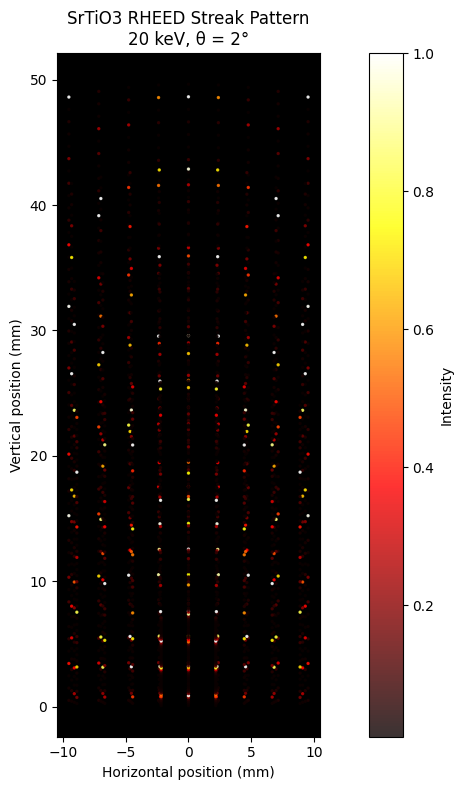

In [18]:
# Additional visualization: scatter plot showing individual streaks
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    detector_coords[:, 0],
    detector_coords[:, 1],
    s=2,
    c=intensities,
    cmap='hot',
    alpha=0.8,
)
ax.set_facecolor('black')
ax.set_xlabel('Horizontal position (mm)')
ax.set_ylabel('Vertical position (mm)')
ax.set_title('SrTiO3 RHEED Streak Pattern\n20 keV, θ = 2°')
ax.set_aspect('equal')
plt.colorbar(scatter, label='Intensity')
plt.tight_layout()
plt.show()

# Test Multislice Simulator

Now let's test the new multislice (dynamical) simulator with the SlicedCrystal!

In [19]:
# Convert the SlicedCrystal to PotentialSlices
potential = rh.simul.sliced_crystal_to_potential(
    sliced_crystal=slab_111,
    slice_thickness=2.0,  # 2 Å per slice
    pixel_size=0.5,  # 0.5 Å pixels (balance between accuracy and speed)
    voltage_kv=voltage_kV
)

print(f"PotentialSlices created:")
print(f"  Shape: {potential.slices.shape}")
print(f"  Slice thickness: {potential.slice_thickness} Å")
print(f"  Pixel size: ({potential.x_calibration}, {potential.y_calibration}) Å")

PotentialSlices created:
  Shape: (10, 300, 300)
  Slice thickness: 2.0 Å
  Pixel size: (0.5, 0.5) Å


## Simulate RHEED pattern using multislice

This uses the dynamical diffraction algorithm that accounts for multiple scattering.

In [20]:
# Simulate RHEED pattern with multislice
pattern_multislice = rh.simul.multislice_simulator(
    potential_slices=potential,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    phi_deg=90.0,  # Vertical streaks
    detector_distance=detector_distance,
    detector_width=200.0,  # mm
    detector_height=200.0,  # mm
    detector_pixels_x=256,  # Reduced for speed
    detector_pixels_y=256,
)

print(f"Multislice RHEED pattern:")
print(f"  Number of points: {len(pattern_multislice.intensities)}")
print(f"  Intensity range: [{pattern_multislice.intensities.min():.2e}, {pattern_multislice.intensities.max():.2e}]")

Multislice RHEED pattern:
  Number of points: 47045
  Intensity range: [2.34e-08, 8.00e+09]


## Compare kinematic vs multislice

Kinematic approximation: single scattering, fast, good for thin samples
Multislice: multiple scattering, slower, accurate for thick samples

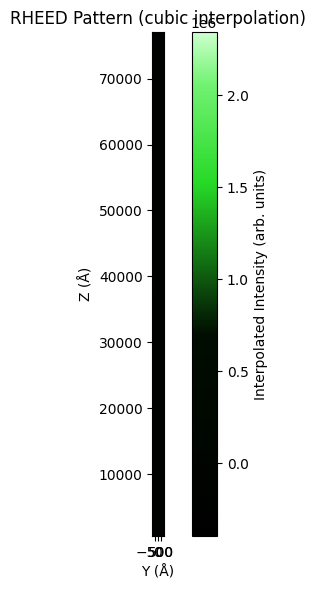

In [21]:
# Plot the multislice RHEED pattern
rh.plots.plot_rheed(pattern_multislice, grid_size=512, interp_type="cubic")